# hand-written d2l BERT

## Attention

注意力就是利用query与key-value对搜索的方式来决定权重，注意力分数是query和key的相似度，注意力权重是分数的softmax结果

### Attention的可视化

In [21]:
import torch
from d2l import torch as d2l

#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

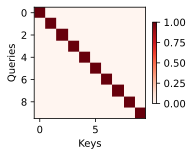

In [22]:
# 我们使用一个简单的例子进行演示。在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

### masked softmax

In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
# 遮蔽softmax操作：填充的东西不去算softmax，后面填充的无效位置
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [5]:
# how masked_softmax work
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3])))

print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))

tensor([[[0.4095, 0.5905, 0.0000, 0.0000],
         [0.4538, 0.5462, 0.0000, 0.0000]],

        [[0.2160, 0.5174, 0.2666, 0.0000],
         [0.3727, 0.3274, 0.2999, 0.0000]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4149, 0.2577, 0.3274, 0.0000]],

        [[0.7058, 0.2942, 0.0000, 0.0000],
         [0.2516, 0.3179, 0.1826, 0.2480]]])


### Additive Attention

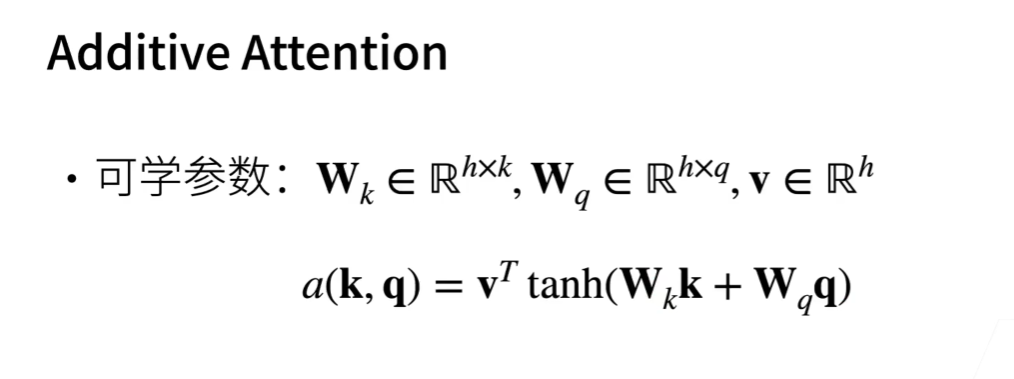
    
    等价于将key和value合并起来后放入到一个隐藏大小为H，输出大小为1的单隐藏层MLP
    好处是q,k,v可以为任意形状

In [6]:
# 加性注意力
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # valid_lens就是可以考虑用q乘以多少k-v对
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1) # 维度不同，广播强行加
        features = torch.tanh(features) # 激活
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values) # batch matmul 批的矩阵乘法
        # 对weight做dropout，就是不看哪一些k-v pair

In [7]:
# 演示
# batch_size = 2,1个query，query长度为20；batch_size = 2,2个key，key长度为2
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6]) # 第一个看前两个k-v对，第二个看前6个

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

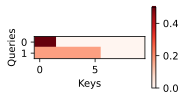

In [10]:
# 注意力权重
%matplotlib inline
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')
# 结果为前两个和前6个，由于数值一样，权重也一样

### Dot Product Attention

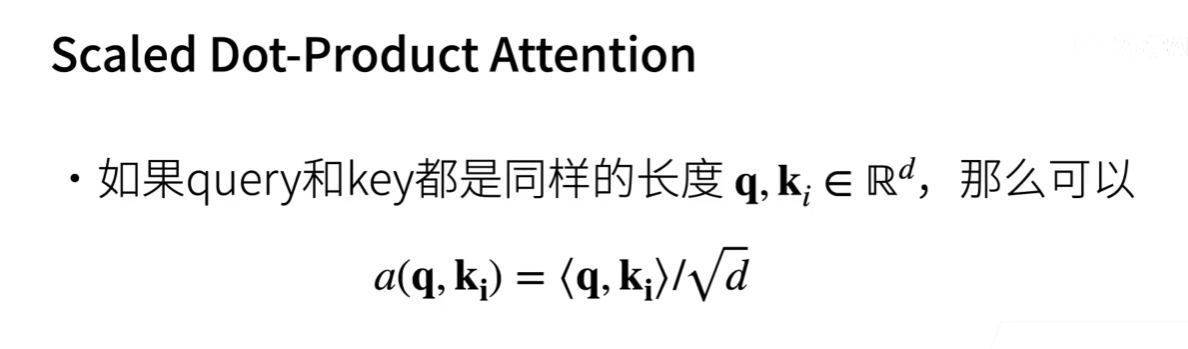

    q,k同样长度时候，直接将query和key做内积
    不用学参数，速度较快，实现简单

In [11]:
# 缩放点积注意力
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        # 这个注意力不需要学参数，实现简单
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        # 不需要权重，直接乘起来即可
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [12]:
# 演示上述的DotProductAttention类
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

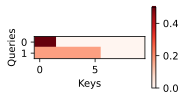

In [13]:
# 均匀的注意力权重
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## self-Attention & position encoding

对于给定序列X1,X2...XN.自注意力池化层将Xi同时当做key，value，query来对序列抽取特征得到y1,...yn

In [14]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
# 自注意力
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [16]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

transformer中的position encoding被证明为无用功，在BERT中就发现直接输入位置信息让BERT学也有同样的效果，不需要这么哲学的变换sin与cos

In [17]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(
                10000,
                torch.arange(0, num_hiddens, 2, dtype=torch.float32) /
                num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

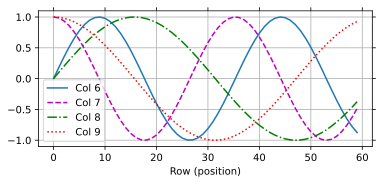

In [18]:
# 行代表标记在序列中的位置，列代表位置编码的不同维度
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

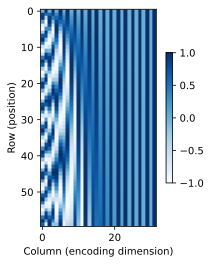

In [20]:
# 在编码维度上降低频率
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

## Multi-Head Attention

多头就是用多个，试用多个不同初始化的注意力，比如让某些抽短距离某些抽长距离

In [34]:
import math
import torch
from torch import nn
from d2l import torch as d2l

在实现过程中，我们选择缩放点积注意力作为每一个注意力头。为了避免计算成本和参数数量的大幅增长，我们设定  pq=pk=pv=po/h 。值得注意的是，如果我们将查询、键和值的线性变换的输出数量设置为  pqh=pkh=pvh=po ，则可以并行计算  h  个头。在下面的实现中， po  是通过参数 num_hiddens 指定的。

In [37]:
#选择缩放点积注意力作为每一个注意力头
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # `queries`, `keys`, or `values` 的形状:
        # (`batch_size`, 查询或者“键－值”对的个数, `num_hiddens`)
        # `valid_lens`　的形状:
        # (`batch_size`,) or (`batch_size`, 查询的个数)
        # 经过变换后，输出的 `queries`, `keys`, or `values`　的形状:
        # (`batch_size` * `num_heads`, 查询或者“键－值”对的个数,
        # `num_hiddens` / `num_heads`)
        # 不用for loop，用reshape并行做完
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴 0，将第一项（标量或者矢量）复制 `num_heads` 次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # `output` 的形状: (`batch_size` * `num_heads`, 查询的个数,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # `output_concat` 的形状: (`batch_size`, 查询的个数, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

为了能够使多个头并行计算，上面的 MultiHeadAttention 类使用了下面定义的两个转置函数。具体来说，transpose_output 函数反转了 transpose_qkv 函数的操作。

In [38]:
#@save
def transpose_qkv(X, num_heads):
    # 输入 `X` 的形状: (`batch_size`, 查询或者“键－值”对的个数, `num_hiddens`).
    # 输出 `X` 的形状: (`batch_size`, 查询或者“键－值”对的个数, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出 `X` 的形状: (`batch_size`, `num_heads`, 查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # `output` 的形状: (`batch_size` * `num_heads`, 查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转 `transpose_qkv` 函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

让我们使用键和值相同的小例子来测试我们编写的 MultiHeadAttention 类。多头注意力输出的形状是 (batch_size, num_queries, num_hiddens)

In [39]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [40]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## Transformer

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

基于位置的前馈网络

In [2]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
# 改变张量的最里层维度的尺寸
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.5152, -0.2346, -0.6906,  0.3856, -0.0729, -0.9465, -0.5521, -0.2345],
        [-0.5152, -0.2346, -0.6906,  0.3856, -0.0729, -0.9465, -0.5521, -0.2345],
        [-0.5152, -0.2346, -0.6906,  0.3856, -0.0729, -0.9465, -0.5521, -0.2345]],
       grad_fn=<SelectBackward>)

In [4]:
# 对比不同维度的层归一化和批量归一化的效果
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


In [5]:
# 使用残差连接和层归一化
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
# 加法操作后输出张量的形状相同
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

实现编码器中的一个层

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens)) # self-attetion就是X自己qkv三连
        return self.addnorm2(Y, self.ffn(Y))

Transformer编码器中的任何层都不会改变其输入的形状

In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

Transformer编码器

In [9]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # 乘法是为了规范化
        self.attention_weights = [None] * len(self.blks) # 为了可视化弄得
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens) # 每次钻一下
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [10]:
# 创建一个两层的Transformer编码器
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

Transformer解码器也是由多个相同的层组成

In [11]:
class DecoderBlock(nn.Module):
    """解码器中第 i 个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [54]:
# 编码器和解码器的特征维度都是num_hiddens
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Transformer解码器

In [12]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size) # 英语法语翻译，用vocab

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
# -*- coding=utf-8 -*-
num_hiddens, num_layers, dropout, batch_size, num_steps = 16, 1, 0.1, 8, 10
lr, num_epochs, device = 0.005, 2, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
# 将一些英语句子翻译成法语
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

In [ ]:
# 可视化Transformer 的注意力权重
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

In [ ]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

In [ ]:
# 为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

In [ ]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [ ]:
# 输出序列的查询不会与输入序列中填充位置的标记进行注意力计算
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

## BERT

Bidirectional Encoder Representations from Transformers

### BERT model

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

In [17]:
# Input Representation
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2) # 加2是两个<>
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [18]:
# BERTEncoder class
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock( # transformer encoder搬过来
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 让它可学，就随机初始化就可以了，包进parameter
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [19]:
# Inference of BERTEncoder
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

tokens = torch.randint(0, vocab_size, (2, 8)) # batchs_size-2，句子长度-8
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [20]:
# Masked Language Modeling - 多分类
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens), # BERT后面接MLP
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size)) # 做vocab_size大小的分类

    def forward(self, X, pred_positions): # X为BERT_ENCODER的输出
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions] # 把masked 位置的特征拿出来
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X) # 特征丢进去做预测
        return mlm_Y_hat

In [21]:
# The forward inference of MaskLM
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [22]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [25]:
# Next Sentence Prediction - 二分类
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        return self.output(X)

In [26]:
# The forward inference of an NextSentencePred
encoded_X = torch.flatten(encoded_X, start_dim=1)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [27]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

Putting All Things Together

In [28]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh()) # 给nsp用的
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :])) # 将所有[cls]的向量抽出来
        return encoded_X, mlm_Y_hat, nsp_Y_hat

### Dataset for Pretrain BERT

In [ ]:
import os
import random
import torch
from d2l import torch as d2l

In [ ]:
# The WikiText-2 dataset - 几百MB小型wiki数据集
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [ ]:
# Generating the Next Sentence Prediction Task
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [ ]:
# Generating the Masked Language Modeling Task
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [ ]:
# Append the special “<mask>” tokens to the inputs
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [ ]:
# The WikiText-2 dataset for pretraining BERT
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
# Download and WikiText-2 dataset and generate pretraining examples
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [ ]:
# Print out the shapes of a minibatch of BERT pretraining examples
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

In [ ]:
len(vocab)

### Pretrain BERT

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [ ]:
# A small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss() # 本质pretrain的也是分类任务

In [ ]:
# Computes the loss for both the masked language modeling and next sentence prediction tasks
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1) # 被pad的东西就不去预测
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [ ]:
# Pretrain BERT (net) on the WikiText-2 (train_iter) dataset
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached: # pretrain数据太大，所以不用epoch，step其实就是batch
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [ ]:
# Representing Text with BERT - BERT其实也是特征抽取器，本质为一个高级encoder
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [ ]:
# Consider the sentence "a crane is flying"
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :] # 拿出所有cls
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]
# 应该是1，6，128和1，128，因为还有两个分隔符，每个token一个hidden vector

In [ ]:
# Now consider a sentence pair "a crane driver came" and "he just left"
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

### fine-tune BERT

#### Natural Language Inference and the Dataset
Stanford Natural Language Inference (SNLI) Corpus

In [ ]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [ ]:
# Reading the Dataset
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
# Print the first 3 pairs
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

In [ ]:
# Labels "entailment", "contradiction", and "neutral" are balanced
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

In [ ]:
# Defining a Class for Loading the Dataset
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [ ]:
# Putting All Things Together
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

In [ ]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

#### fine-tune BERT on SNLI

In [ ]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# Loading Pretrained BERT
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [ ]:
# Load pretrained BERT parameters
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [ ]:
# The Dataset for Fine-Tuning BERT
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)# NLP的预处理很慢，所以必须用多进程，CV的operator都是C++写的
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
# This MLP transforms the BERT representation of the special “<cls>” token into three outputs of natural language inference
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :])) # 拿到CLS

net = BERTClassifier(bert)

In [ ]:
# The training
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# torch_hand_written_BERT

## Pytorch代码Transformer

In [ ]:
'''数据准备'''
# Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

             # Encoder_input    Decoder_input        Decoder_output
sentences = [['我 是 学 生 P' , 'S I am a student'   , 'I am a student E'],         # S: 开始符号
             ['我 喜 欢 学 习', 'S I like learning P', 'I like learning P E'],      # E: 结束符号
             ['我 是 男 生 P' , 'S I am a boy'       , 'I am a boy E']]             # P: 占位符号，如果当前句子不足固定长度用P占位

src_vocab = {'P':0, '我':1, '是':2, '学':3, '生':4, '喜':5, '欢':6,'习':7,'男':8}   # 词源字典  字：索引
src_idx2word = {src_vocab[key]: key for key in src_vocab}
src_vocab_size = len(src_vocab)                                                     # 字典字的个数
tgt_vocab = {'S':0, 'E':1, 'P':2, 'I':3, 'am':4, 'a':5, 'student':6, 'like':7, 'learning':8, 'boy':9}
idx2word = {tgt_vocab[key]: key for key in tgt_vocab}                               # 把目标字典转换成 索引：字的形式
tgt_vocab_size = len(tgt_vocab)                                                     # 目标字典尺寸
src_len = len(sentences[0][0].split(" "))                                           # Encoder输入的最大长度
tgt_len = len(sentences[0][1].split(" "))                                           # Decoder输入输出最大长度

# 把sentences 转换成字典索引
def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
      enc_input = [[src_vocab[n] for n in sentences[i][0].split()]] 
      dec_input = [[tgt_vocab[n] for n in sentences[i][1].split()]] 
      dec_output = [[tgt_vocab[n] for n in sentences[i][2].split()]] 
      enc_inputs.extend(enc_input)
      dec_inputs.extend(dec_input)
      dec_outputs.extend(dec_output)
    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)
enc_inputs, dec_inputs, dec_outputs = make_data(sentences)

#自定义数据集函数
class MyDataSet(Data.Dataset):
  def __init__(self, enc_inputs, dec_inputs, dec_outputs):
    super(MyDataSet, self).__init__()
    self.enc_inputs = enc_inputs
    self.dec_inputs = dec_inputs
    self.dec_outputs = dec_outputs
  
  def __len__(self):
    return self.enc_inputs.shape[0]
  
  def __getitem__(self, idx):
    return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

loader = Data.DataLoader(MyDataSet(enc_inputs, dec_inputs, dec_outputs), 2, True) 

sentences 里一共有三个训练数据，中文->英文。把Encoder_input、Decoder_input、Decoder_output转换成字典索引，例如"学"->3、"student"->6。再把数据转换成batch大小为2的分组数据，3句话一共可以分成两组，一组2句话、一组1句话。src_len表示中文句子固定最大长度，tgt_len 表示英文句子固定最大长度。

In [ ]:
'''参数设置'''
d_model = 512   # 字 Embedding 的维度
d_ff = 2048     # 前向传播隐藏层维度
d_k = d_v = 64  # K(=Q), V的维度 
n_layers = 6    # 有多少个encoder和decoder
n_heads = 8     # Multi-Head Attention设置为8

In [ ]:
'''sin位置信息：生成位置信息矩阵，直接加上输入的Embedding上，得到带有位置信息的词嵌入'''
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout) 
        pos_table = np.array([
        [pos / np.power(10000, 2 * i / d_model) for i in range(d_model)]
        if pos != 0 else np.zeros(d_model) for pos in range(max_len)])
        pos_table[1:, 0::2] = np.sin(pos_table[1:, 0::2])                  # 字嵌入维度为偶数时
        pos_table[1:, 1::2] = np.cos(pos_table[1:, 1::2])                  # 字嵌入维度为奇数时
        self.pos_table = torch.LongTensor(pos_table).unsqueeze(1).cuda()

    def forward(self, enc_inputs):                                         # enc_inputs: [seq_len, batch_size, d_model]
        enc_inputs += self.pos_table[:enc_inputs.size(0), :]
        return self.dropout(enc_inputs.cuda())

In [ ]:
'''Mask掉停用词：Mask句子中没有实际意义的占位符，例如'我 是 学 生 P' ，P对应句子没有实际意义，随意需要被Mask，Encoder_input 和Decoder_input占位符都需要被Mask '''
def get_attn_pad_mask(seq_q, seq_k):                       # seq_q: [batch_size, seq_len] ,seq_k: [batch_size, seq_len]
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)          # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1, len_k]
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # 扩展成多维度

In [ ]:
'''Decoder 输入 Mask'''
def get_attn_subsequence_mask(seq):                               # seq: [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)          # 生成上三角矩阵,[batch_size, tgt_len, tgt_len]
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  #  [batch_size, tgt_len, tgt_len]
    return subsequence_mask       

用来Mask未来输入信息，返回的是一个上三角矩阵。比如我们在中英文翻译时候，会先把"我是学生"整个句子输入到Encoder中，得到最后一层的输出后，才会在Decoder输入"S I am a student"（s表示开始）,但是"S I am a student"这个句子我们不会一起输入，而是在T0时刻先输入"S"预测，预测第一个词"I"；在下一个T1时刻，同时输入"S"和"I"到Decoder预测下一个单词"am"；然后在T2时刻把"S,I,am"同时输入到Decoder预测下一个单词"a"，依次把整个句子输入到Decoder,预测出"I am a student E"

In [ ]:
'''计算注意力信息、残差和归一化'''
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):                             # Q: [batch_size, n_heads, len_q, d_k]
                                                                       # K: [batch_size, n_heads, len_k, d_k]
                                                                       # V: [batch_size, n_heads, len_v(=len_k), d_v]
                                                                       # attn_mask: [batch_size, n_heads, seq_len, seq_len]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)   # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9)                           # 如果时停用词P就等于 0 
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)                                # [batch_size, n_heads, len_q, d_v]
        return context, attn
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):    # input_Q: [batch_size, len_q, d_model]
                                                                # input_K: [batch_size, len_k, d_model]
                                                                # input_V: [batch_size, len_v(=len_k), d_model]
                                                                # attn_mask: [batch_size, seq_len, seq_len]
        residual, batch_size = input_Q, input_Q.size(0)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)              # attn_mask : [batch_size, n_heads, seq_len, seq_len]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)          # context: [batch_size, n_heads, len_q, d_v]
                                                                                 # attn: [batch_size, n_heads, len_q, len_k]
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context)                                                # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual), attn

计算注意力信息，W^Q,W^K,W^V矩阵会拆分成8个小矩阵。细节请看2.2章。注意传入的input_Q, input_K, input_V，在Encoder和Decoder的第一次调用传入的三个矩阵是相同的，但Decoder的第二次调用传入的三个矩阵input_Q 等于 input_K 不等于 input_V

In [ ]:
'''前馈神经网络FeedForwardNet'''
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False))
        
    def forward(self, inputs):                             # inputs: [batch_size, seq_len, d_model]
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual)   # [batch_size, seq_len, d_model]  

输入inputs ，经过两个全连接成，得到的结果再加上 inputs ，再做LayerNorm归一化。LayerNorm归一化可以理解层是把Batch中每一句话进行归一化

In [ ]:
'''单个encoder'''
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()                                     # 多头注意力机制
        self.pos_ffn = PoswiseFeedForwardNet()                                        # 前馈神经网络

    def forward(self, enc_inputs, enc_self_attn_mask):                                # enc_inputs: [batch_size, src_len, d_model]
        #输入3个enc_inputs分别与W_q、W_k、W_v相乘得到Q、K、V                          # enc_self_attn_mask: [batch_size, src_len, src_len]
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs,    # enc_outputs: [batch_size, src_len, d_model], 
                                               enc_self_attn_mask)                    # attn: [batch_size, n_heads, src_len, src_len]                                                                   
        enc_outputs = self.pos_ffn(enc_outputs)                                       # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs, attn

In [ ]:
'''整个Encoder'''
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)                     # 把字转换字向量 
        self.pos_emb = PositionalEncoding(d_model)                               # 加入位置信息
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):                                               # enc_inputs: [batch_size, src_len]
        enc_outputs = self.src_emb(enc_inputs)                                   # enc_outputs: [batch_size, src_len, d_model]
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)  # enc_outputs: [batch_size, src_len, d_model]   
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)           # enc_self_attn_mask: [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)  # enc_outputs :   [batch_size, src_len, d_model], 
                                                                                 # enc_self_attn : [batch_size, n_heads, src_len, src_len]
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

第一步，中文字索引进行Embedding，转换成512维度的字向量。第二步，在子向量上面加上位置信息。第三步，Mask掉句子中的占位符号。第四步，通过6层的encoder（上一层的输出作为下一层的输入）

In [ ]:
'''单个decoder'''
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask): # dec_inputs: [batch_size, tgt_len, d_model]
                                                                                       # enc_outputs: [batch_size, src_len, d_model]
                                                                                       # dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
                                                                                       # dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, 
                                                 dec_inputs, dec_self_attn_mask)   # dec_outputs: [batch_size, tgt_len, d_model]
                                                                                   # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, 
                                                enc_outputs, dec_enc_attn_mask)    # dec_outputs: [batch_size, tgt_len, d_model]
                                                                                   # dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        dec_outputs = self.pos_ffn(dec_outputs)                                    # dec_outputs: [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

decoder两次调用MultiHeadAttention时，第一次调用传入的 Q，K，V 的值是相同的，都等于dec_inputs，第二次调用 Q 矩阵是来自Decoder的输入。K，V 两个矩阵是来自Encoder的输出，等于enc_outputs

In [ ]:
'''整个Decoder'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):                               # dec_inputs: [batch_size, tgt_len]
                                                                                          # enc_intpus: [batch_size, src_len]
                                                                                          # enc_outputs: [batsh_size, src_len, d_model]
        dec_outputs = self.tgt_emb(dec_inputs)                                            # [batch_size, tgt_len, d_model]       
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1).cuda()    # [batch_size, tgt_len, d_model]
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda()         # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda()     # [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + 
                                       dec_self_attn_subsequence_mask), 0).cuda()         # [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)                     # [batc_size, tgt_len, src_len]
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:                             # dec_outputs: [batch_size, tgt_len, d_model]
                                                              # dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
                                                              # dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

第一步，英文字索引进行Embedding，转换成512维度的字向量。第二步，在子向量上面加上位置信息。第三步，Mask掉句子中的占位符号和输出顺序细节见3.1。第四步，通过6层的decoder（上一层的输出作为下一层的输入）

In [ ]:
'''Trasformer'''
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.Encoder = Encoder().cuda()
        self.Decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False).cuda()
    def forward(self, enc_inputs, dec_inputs):                         # enc_inputs: [batch_size, src_len]  
                                                                       # dec_inputs: [batch_size, tgt_len]
        enc_outputs, enc_self_attns = self.Encoder(enc_inputs)         # enc_outputs: [batch_size, src_len, d_model], 
                                                                       # enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.Decoder(
            dec_inputs, enc_inputs, enc_outputs)                       # dec_outpus    : [batch_size, tgt_len, d_model], 
                                                                       # dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], 
                                                                       # dec_enc_attn  : [n_layers, batch_size, tgt_len, src_len]
        dec_logits = self.projection(dec_outputs)                      # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

Trasformer的整体结构，输入数据先通过Encoder，再同个Decoder，最后把输出进行多分类，分类数为英文字典长度，也就是判断每一个字的概率

In [ ]:
'''定义网络'''
model = Transformer().cuda()
criterion = nn.CrossEntropyLoss(ignore_index=0)     #忽略 占位符 索引为0.
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

In [ ]:
'''训练Transformer'''
for epoch in range(50):
    for enc_inputs, dec_inputs, dec_outputs in loader:         # enc_inputs : [batch_size, src_len]
                                                               # dec_inputs : [batch_size, tgt_len]
                                                               # dec_outputs: [batch_size, tgt_len]
      
      enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()                                                             
      outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
                                                               # outputs: [batch_size * tgt_len, tgt_vocab_size]
      loss = criterion(outputs, dec_outputs.view(-1))
      print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [ ]:
'''测试网络'''
def test(model, enc_input, start_symbol):
    # Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    enc_outputs, enc_self_attns = model.Encoder(enc_input)
    dec_input = torch.zeros(1, tgt_len).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, tgt_len):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.Decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

enc_inputs, _, _ = next(iter(loader))
predict_dec_input = test(model, enc_inputs[0].view(1, -1).cuda(), start_symbol=tgt_vocab["S"])
predict, _, _, _ = model(enc_inputs[0].view(1, -1).cuda(), predict_dec_input)
predict = predict.data.max(1, keepdim=True)[1]

print([src_idx2word[int(i)] for i in enc_inputs[0]], '->', 
[idx2word[n.item()] for n in predict.squeeze()])
# ['我', '是', '男', '生', 'P'] -> ['I', 'am', 'a', 'boy', 'E']

In [ ]:
'''打印Transformer模型'''
print(model)
'''
Transformer(
(Encoder): Encoder(
(src_emb): Embedding(9, 512)
(pos_emb): PositionalEncoding(
(dropout): Dropout(p=0.1, inplace=False)
)
(layers): ModuleList(
(0): EncoderLayer(
(enc_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(1): EncoderLayer(
(enc_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(2): EncoderLayer(
(enc_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(3): EncoderLayer(
(enc_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(4): EncoderLayer(
(enc_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(5): EncoderLayer(
(enc_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
)
)
(Decoder): Decoder(
(tgt_emb): Embedding(10, 512)
(pos_emb): PositionalEncoding(
(dropout): Dropout(p=0.1, inplace=False)
)
(layers): ModuleList(
(0): DecoderLayer(
(dec_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(dec_enc_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(1): DecoderLayer(
(dec_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(dec_enc_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(2): DecoderLayer(
(dec_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(dec_enc_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(3): DecoderLayer(
(dec_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(dec_enc_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(4): DecoderLayer(
(dec_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(dec_enc_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
(5): DecoderLayer(
(dec_self_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(dec_enc_attn): MultiHeadAttention(
(W_Q): Linear(in_features=512, out_features=512, bias=False)
(W_K): Linear(in_features=512, out_features=512, bias=False)
(W_V): Linear(in_features=512, out_features=512, bias=False)
(fc): Linear(in_features=512, out_features=512, bias=False)
)
(pos_ffn): PoswiseFeedForwardNet(
(fc): Sequential(
(0): Linear(in_features=512, out_features=2048, bias=False)
(1): ReLU()
(2): Linear(in_features=2048, out_features=512, bias=False)
)
)
)
)
)
(projection): Linear(in_features=512, out_features=10, bias=False)
)
'''

## pytorch预训练BERT

In [ ]:
'''头文件'''
import copy
import math
import torch
import torch.nn as nn
import torch.utils.data as Data
from random import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''设置的参数'''
class BertConfig():
    def __init__(self):
          self.attention_probs_dropout_prob= 0.1           # 注意力处dropout值
          self.hidden_act= "gelu"                          # 隐藏层使用的激活函数
          self.hidden_dropout_prob= 0.1                    # 隐藏层处dropout的值
          self.hidden_size= 1024                           # 隐藏层大小，字向量长度
          self.initializer_range= 0.02                     # bert模型初始化方差值
          self.intermediate_size= 4096                     # 前向传播隐藏层大小
          self.max_position_embeddings= 512                # 位置信息长度 512
          self.num_attention_heads= 16                     # 注意力头的个数
          self.num_hidden_layers= 24                       # encoder 层数
          self.type_vocab_size= 2                          # 句子类型，标记第一句话和第二句话
          self.vocab_size= 21128                           # 字典大小21128
          self.seq_length = 40                             # tokens总长度

In [ ]:
'''数据的预处理'''
config = BertConfig()
data = ['有生之年',
        '愿你勇敢',
        '愿你平安',
        '愿你没有苦难',
        '活的简单',
        '愿你累了倦了有人为你分担',
        '愿你每个夜晚都会有美梦作伴',
        '愿你长路漫漫得偿所愿',
        '愿这世间烦恼从此与你无关',
        '愿你遇事全部得你心欢',
        '愿你前程似锦',
        '不凡此生']

#建立字典 编号 <--> 字 的对应关系
s = set([ i for j in data for i in j])
                                                  # 字典大小
word2idx = {'PAD' : 0, 'CLS' : 1, 'SEP' : 2, 'MASK' : 3}             # 特殊字符
for idx, word in enumerate(s):
    word2idx[word] = idx+4                                           # 字   -> 编号
idx2word = {word2idx[key]:key for key in word2idx}                   # 编号 -> 字
vocab_size = len(idx2word)

#把句子的字变成编号
sentences = []
for sentence in data:
    tmp = []
    for i, word in enumerate(sentence):
        tmp.append(word2idx[word])
    sentences.append(tmp)

# 自定义Dataset
batch_size = 32
class MyDataSet(Data.Dataset):
    def __init__(self, data):
        self.sentences = []
        for sentence in data:
            tmp = []
            for i, word in enumerate(sentence):
                tmp.append(word2idx[word])
            self.sentences.append(tmp)
        self.sentences_len = len(self.sentences)
    def __len__(self):
        return len(self.sentences)*2-2  
    def __getitem__(self, idx):
        sentences = copy.deepcopy(self.sentences)       
        input_ids = []
        token_type_ids = []
        next_sentence_label = []

        if idx%2 == 0:
            s = [word2idx['CLS']] + sentences[int(idx//2)] + [word2idx['SEP']] + sentences[int(idx//2)+1] + [word2idx['SEP']]
            input_ids = s+[0]*(config.seq_length-len(s))
            token_type_ids = [0]*(1+len(sentences[int(idx//2)])+1) + [1]*(len(sentences[int(idx//2+1)])+1) + [0]*(config.seq_length-len(s))
            next_sentence_label = [1]
        else:
            rand = int(idx//2)+1
            while rand ==  idx//2+1:
                rand = randint(0, self.sentences_len-1)
            s =[word2idx['CLS']] + sentences[int(idx//2)] + [word2idx['SEP']] + sentences[rand] + [word2idx['SEP']]
            input_ids = s+[0]*(config.seq_length-len(s))
            token_type_ids = [0]*(1+len(sentences[int(idx//2)])+1) + [1]*(len(sentences[rand])+1) + [0]*(config.seq_length-len(s))
            next_sentence_label = [0]
            
        attention_mask = []
        masked_lm_labels = []
        for pos, value in enumerate(input_ids):
            rand = random()
            if value == 0:
                attention_mask.append(0) 
            else:
                attention_mask.append(1)
            if value != 0 and value != 1 and value != 2 and rand < 0.15:   
                    masked_lm_labels.append(input_ids[pos]) 
                    if rand < 0.15*0.8:
                        input_ids[pos] = word2idx["MASK"]
                    elif rand > 0.15*0.9:
                        input_ids[pos] = randint(4, vocab_size)           
            else:  
                masked_lm_labels.append(-1)          
        input_ids = torch.tensor(input_ids)
        token_type_ids = torch.tensor(token_type_ids)
        next_sentence_label = torch.tensor(next_sentence_label)
        attention_mask = torch.tensor(attention_mask)
        masked_lm_labels = torch.tensor(masked_lm_labels)
        return input_ids, token_type_ids, attention_mask, masked_lm_labels, next_sentence_label
data_loader = Data.DataLoader(MyDataSet(data), batch_size, True)

数据预处是采用动态Mask和动态下句随机匹配，每一次迭代，epoch的数据都不同。

    input_ids : 句子的字典索引
    token_type_ids：用1和0区分第一个句子和第二个句子
    attention_mask：标记句子中选出15%的token。
    masked_lm_labels:标记被mask的真实字典索引值。
    next_sentence_label：标记两句话是否连续
建议读者一步一步打印每一个变量输出，对照上文观察得到的结果。

In [ ]:
'''定义激活函数和归一化'''
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}

class BertLayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(BertLayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):                                  
        u = x.mean(-1, keepdim=True)                          # 最后一个维度上求均值，可以理解在字向量上
        s = (x - u).pow(2).mean(-1, keepdim=True)             # 最后一个维度上求均值，可以理解在字向量上
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

In [ ]:
'''BertEmbeddings'''
# Bert的输入
class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):  # input_ids:(batch, seq_length)    token_type_ids:(batch, seq_length) 
        seq_length = input_ids.size(1)                                      
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)   # (seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                        # (batch, seq_length)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        words_embeddings = self.word_embeddings(input_ids)                                   # (batch, seq_length, hidden_size)
        position_embeddings = self.position_embeddings(position_ids)                         # (batch, seq_length, hidden_size)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)                   # (batch, seq_length, hidden_size)
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)                                              # 最后一个维度求归一化
        embeddings = self.dropout(embeddings)                                                    
        return embeddings   

    Token Embeddings：是数据预处理后语句的字典索引。
    Segment Embeddings：标记那些是第一句话，那些是第二句话。
    Position Embeddings：标记这个token在这句话处的位置。
把它们映射到维度相同高维空间，再加起来，input = Token Embeddings + Segment Embeddings + Position Embeddings，得到Encoder的输入

In [ ]:
'''Encoder的Self-Attention Mechanism'''
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        self.num_attention_heads = config.num_attention_heads                            # num_attention_heads个注意力
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)  # 每一个注意力大小1024/16=64
        self.all_head_size = self.num_attention_heads * self.attention_head_size         # all_head_size：16*64=1024
        self.query = nn.Linear(config.hidden_size, self.all_head_size)                   # (hidden_size，attention_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)                     # (hidden_size，attention_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)                   # (hidden_size，attention_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):              # q, k, v 改变形状
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) 
                                                                                   #  new_x_shape:元组(batch，seq_len, num_attention_heads,attention_head_size)
        x = x.view(*new_x_shape)                                                   # (batch，seq_len, num_attention_heads, attention_head_size)
        return x.permute(0, 2, 1, 3)                                               # (batch, num_attention_heads, seq_len, attention_head_size)

    def forward(self, hidden_states, attention_mask):                              # (batch, seq_length, hidden_size)，(batch,1,1,sqe_len)
        mixed_query_layer = self.query(hidden_states)                              # (batch, seq_len, hidden_size)
        mixed_key_layer = self.key(hidden_states)                                  # (batch, seq_len, hidden_size)
        mixed_value_layer = self.value(hidden_states)                              # (batch, seq_len, hidden_size)

        query_layer = self.transpose_for_scores(mixed_query_layer)                 # (batch, num_attention_heads, seq_len, attention_head_size)
        key_layer = self.transpose_for_scores(mixed_key_layer)                     # (batch, num_attention_heads, seq_len, attention_head_size)
        value_layer = self.transpose_for_scores(mixed_value_layer)                 # (batch, num_attention_heads, seq_len, attention_head_size)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))  # (batch, num_attention_heads, seq_len, seq_len)
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)  # (batch, num_attention_heads, seq_len, seq_len)
        attention_scores = attention_scores + attention_mask                       # (batch, num_attention_heads, seq_len, seq_len)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)                     # (batch, num_attention_heads, seq_len, seq_len)
        attention_probs = self.dropout(attention_probs)                            # (batch, num_attention_heads, seq_len, seq_len)

        context_layer = torch.matmul(attention_probs, value_layer)                 # (batch, num_attention_heads, seq_len, attention_head_size)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()             # (batch, seq_len，num_attention_heads, attention_head_size)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)# (batch, seq_len，hidden_size)
        context_layer = context_layer.view(*new_context_layer_shape)               # (batch, seq_len，hidden_size)
        return context_layer                                                       # (batch, seq_len，hidden_size)


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):                   # (batch, seq_len，hidden_size),(batch, seq_len，hidden_size)
        hidden_states = self.dense(hidden_states)                     # (batch, seq_len，hidden_size)
        hidden_states = self.dropout(hidden_states)                   # (batch, seq_len，hidden_size)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)  # (batch, seq_len，hidden_size)
        return hidden_states                                          # (batch, seq_len，hidden_size)


class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):  # hidden_states:(batch, seq_length, hidden_size)，attention_mask:(batch,1,1,sqe_len)
        self_output = self.self(input_tensor, attention_mask)         # (batch, seq_len，hidden_size)
        attention_output = self.output(self_output, input_tensor)     # (batch, seq_len，hidden_size)
        return attention_output                                       # (batch, seq_len，hidden_size)

先计算出第一个token与句子中的每一个token的注意力分数（包括第一个token），再用计算出的注意力分数乘以对应token的信息，然后加在一起，得到的结果就是第一个token与句子中所有token的加权和信息，依次更新每一个token与句子的注意力信息

In [ ]:
'''Encoder的Add & Layer normalization:利用了残差网络可能增加网络深度性，归一化可以加快网络收敛'''
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):                               # (batch, seq_len，hidden_size)
        hidden_states = self.dense(hidden_states)                   # (batch, seq_len，intermediate_size)
        hidden_states = self.intermediate_act_fn(hidden_states)     # (batch, seq_len，intermediate_size)
        return hidden_states

class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):                 # (batch, seq_len，intermediate_size)
        hidden_states = self.dense(hidden_states)                   # (batch, seq_len，hidden_size)
        hidden_states = self.dropout(hidden_states)                 # (batch, seq_len，hidden_size)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)# (batch, seq_len，hidden_size)
        return hidden_states                                        # (batch, seq_len，hidden_size)

class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):  # hidden_states:(batch, seq_length, hidden_size)，attention_mask:(batch,1,1,sqe_len)
        attention_output = self.attention(hidden_states, attention_mask)      # (batch, seq_len，hidden_size)
        intermediate_output = self.intermediate(attention_output)             # (batch, seq_len，intermediate_size)
        layer_output = self.output(intermediate_output, attention_output)     # (batch, seq_len，hidden_size)
        return layer_output                           

In [ ]:
'''Encoder : 组合成24层的Encoder'''
class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):  # hidden_states:(batch, seq_length, hidden_size)，attention_mask:(batch,1,1,sqe_len)      
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)        # (batch, seq_len，hidden_size)
            if output_all_encoded_layers:                                      # 输出每一层的内容
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:                                      # 输出最后一层的内容                  
            all_encoder_layers.append(hidden_states)                           # (batch, seq_len，hidden_size)
        return all_encoder_layers                                              # (batch, seq_len，hidden_size)

In [ ]:
'''BertPooler（处理CLS信息）: 获取Encoder最后已层输出的第一个token，也就是"CLS"的编码后的特征信息'''
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):                          # (batch, seq_length, hidden_size)
        first_token_tensor = hidden_states[:, 0]               # 每个句子的第一个token (batch, hidden_size)
        pooled_output = self.dense(first_token_tensor)         # (batch, hidden_size)
        pooled_output = self.activation(pooled_output)         # (batch, hidden_size)
        return pooled_output                                   # (batch, hidden_size)

In [ ]:
'''预训练模型加载，保存'''
class BertPreTrainedModel(nn.Module):
    #处理权重和下载、加载模型
    def __init__(self, config, *inputs, **kwargs):
        super(BertPreTrainedModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        # 初始化权重
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *inputs, **kwargs):
       # 预先训练的模型下载并缓存预先训练的模型文件。
        state_dict = kwargs.get('state_dict', None)
        kwargs.pop('state_dict', None)
        cache_dir = kwargs.get('cache_dir', None)
        kwargs.pop('cache_dir', None)
        from_tf = kwargs.get('from_tf', False)
        kwargs.pop('from_tf', None)

        if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
        else:
            archive_file = pretrained_model_name_or_path
        try:
            resolved_archive_file = cached_path(archive_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name_or_path,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),archive_file))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file) or from_tf:
            serialization_dir = resolved_archive_file
        else:
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        config_file = os.path.join(serialization_dir, CONFIG_NAME)   # 加载 config文件
        if not os.path.exists(config_file):
            config_file = os.path.join(serialization_dir, BERT_CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        model = cls(config, *inputs, **kwargs)
        if state_dict is None and not from_tf:
            weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
            state_dict = torch.load(weights_path, map_location='cpu')
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        if from_tf:
            weights_path = os.path.join(serialization_dir, TF_WEIGHTS_NAME)
            return load_tf_weights_in_bert(model, weights_path)
        old_keys = []
        new_keys = []
        for key in state_dict.keys():
            new_key = None
            if 'gamma' in key:
                new_key = key.replace('gamma', 'weight')
            if 'beta' in key:
                new_key = key.replace('beta', 'bias')
            if new_key:
                old_keys.append(key)
                new_keys.append(new_key)
        for old_key, new_key in zip(old_keys, new_keys):
            state_dict[new_key] = state_dict.pop(old_key)

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        start_prefix = ''
        if not hasattr(model, 'bert') and any(s.startswith('bert.') for s in state_dict.keys()):
            start_prefix = 'bert.'
        load(model, prefix=start_prefix)
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(model.__class__.__name__, unexpected_keys))
        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(model.__class__.__name__, "\n\t".join(error_msgs)))
        return model

In [ ]:
'''BertModel :把前面定义的类组合成Bert '''
class BertModel(BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)                        # (batch,1,1,sqe_len)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # (batch,1,1,sqe_len)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0                      # 只计算被标记的位置(batch,1,1,sqe_len)
        embedding_output = self.embeddings(input_ids, token_type_ids)                             # (batch, seq_length, hidden_size)
        encoded_layers = self.encoder(embedding_output,                                           # (batch, seq_length, hidden_size)
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]                                                      # 取出encoder最后一层输出(batch, seq_length, hidden_size)           
        pooled_output = self.pooler(sequence_output)                                              # 返回CLS的特征(batch, hidden_size)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output            #  返回最后一层的数据：(batch, seq_length, hidden_size),返回CLS的特征(batch, hidden_size)

In [ ]:
'''预训练BertPreTrainingHeads（可以理解成bert接的下游任务）: 
对预训练做准备，把"CLS"转换成大小为（batch, 2）。把Bert整个输出转换成大小为(batch, seq_length,vocab_size)，方便后面做损失'''
class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states):                                     # bert输出(batch, seq_length, hidden_size)
        hidden_states = self.dense(hidden_states)                         # bert输出(batch, seq_length, hidden_size)
        hidden_states = self.transform_act_fn(hidden_states)              # 激活函数
        hidden_states = self.LayerNorm(hidden_states)                     # 归一化
        return hidden_states                                              # (batch, seq_length, hidden_size)

class BertLMPredictionHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                 bert_model_embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))

    def forward(self, hidden_states):                                      # bert输出(batch, seq_length, hidden_size)
        hidden_states = self.transform(hidden_states)                      # (batch, seq_length, hidden_size)
        hidden_states = self.decoder(hidden_states) + self.bias            # (batch, seq_length,vocab_size)   
        return hidden_states                                               # (batch, seq_length,vocab_size) 

class BertPreTrainingHeads(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):                # bert输出(batch, seq_length, hidden_size),CLS的特征(batch, hidden_size)
        prediction_scores = self.predictions(sequence_output)         # (batch, seq_length,vocab_size) 
        seq_relationship_score = self.seq_relationship(pooled_output) # (batch, 2)
        return prediction_scores, seq_relationship_score              # (batch, seq_length,vocab_size) ,(batch, 2)

In [ ]:
'''预训练模型定义'''
class BertForPreTraining(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,output_all_encoded_layers=False)
        # 返回encoder最后一层(batch, seq_length, hidden_size),返回CLS的特征(batch, hidden_size)
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)    # (batch, seq_length, vocab_size) ,(batch, 2)
        if masked_lm_labels is not None and next_sentence_label is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)                                     # 忽略标签为-1的loss
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
                                                                                                # 计算Mask的loss的平均值                
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
                                                                                                # 计算两句话是否连续
            total_loss = masked_lm_loss + next_sentence_loss                                    # 俩个loss加起来
            return total_loss
        else:
            return prediction_scores, seq_relationship_score                                    # (batch, seq_length, vocab_size) ,(batch, 2)
config = BertConfig()
model = BertForPreTraining(config).to(device)
learnrate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learnrate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learnrate, momentum=0.99)

定义模型，计算损失：第一部分masked_lm_loss 计算被mask的token，第二部分next_sentence_loss 计算是否两句话是连续，然后加在一起做返回。total_loss = masked_lm_loss + next_sentence_loss 。

注意nn.CrossEntropyLoss(ignore_index=-1)是忽略标签为-1的损失

In [ ]:
'''训练'''
epochs = 10
for epoch in range(epochs):
    for input_ids, token_type_ids, attention_mask, masked_lm_labels, next_sentence_label in data_loader:
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        masked_lm_labels = masked_lm_labels.to(device)
        next_sentence_label = next_sentence_label.to(device)
        loss = model(input_ids, token_type_ids, attention_mask, masked_lm_labels, next_sentence_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

## pytorch微调BERT

情感分析数据集 链接：https://pan.baidu.com/s/1qT1B5vpRP7z2hNu7gQjMGg
提取码：1111

In [ ]:
'''数据预处理'''
import pandas
from random import *
import re
f = pandas.read_csv("Data.csv")
x = pandas.concat((f.iloc[:, 1:], f.iloc[:, :1]),axis = 1, ignore_index = False)
x = list(x.values)
shuffle(x)
y = []
g = []
for i in x:
    y = re.sub("[.,!?\\-。，？~！\" ]", "", str(i[0]))
    y = y + "\t" + str(i[1])
    g.append(y)
g = pandas.DataFrame(g)
train = g[:8000]
dev = g[8000:10000]
test = g[10000:]
train.to_csv("train.txt", header=0, index=0)
dev.to_csv("dev.txt", header=0, index=0)
test.to_csv("test.txt", header=0, index=0)

In [ ]:
'''头文件'''
import math
import tqdm
import numpy
import torch
import torch.nn as nn
import torch.utils.data as Data
from random import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''模型参数（结构相关的参数都不能修改）'''
class BertConfig():
    def __init__(self):
          self.attention_probs_dropout_prob= 0.1           # 注意力处dropout值
          self.hidden_act= "gelu"                          # 隐藏层使用的激活函数
          self.hidden_dropout_prob= 0.1                    # 隐藏层处dropout的值
          self.hidden_size= 1024                           # 隐藏层大小，字向量长度
          self.initializer_range= 0.02                     # bert模型初始化方差值
          self.intermediate_size= 4096                     # 前向传播隐藏层大小
          self.max_position_embeddings= 512                # 位置信息长度 512
          self.num_attention_heads= 16                     # 注意力头的个数
          self.num_hidden_layers= 24                       # encoder 层数
          self.type_vocab_size= 2                          # 句子类型，标记第一句话和第二句话
          self.vocab_size= 21128                           # 字典大小21128
          self.seq_length = 40                             # tokens总长度
batch_size = 32

In [ ]:
'''数据加载'''
def load_dataset(path, pad_size=32):
    contents = []
    word2idx = {}
    idx2word = {}
    with open("./vocab.txt", 'r', encoding='UTF-8') as f:
        idx2word = {idx: line.strip() for idx, line in  enumerate(tqdm.tqdm(f))}
        word2idx = {idx2word[key]: key for key in  idx2word}
    with open(path, 'r', encoding='UTF-8') as f:
        for line in tqdm.tqdm(f):
            token_ids = []
            lin = line.strip()
            if not lin:
                continue
            content, label = lin.split('\t')
            token_ids.append (word2idx['[CLS]'])
            for key in content:
                token_ids.append(word2idx.get(key, 0))
            seq_len = len(token_ids)
            mask = []
            if pad_size:
                if seq_len < pad_size:
                    mask = [1] * len(token_ids) + [0] * (pad_size - seq_len)
                    token_ids += ([0] * (pad_size - seq_len))
                else:
                    mask = [1] * pad_size
                    token_ids = token_ids[:pad_size]
                    seq_len = pad_size
            contents.append((numpy.array(token_ids), int(label), seq_len, numpy.array(mask)))
    return contents
train = load_dataset("./train.txt")
dev = load_dataset("./dev.txt")
test = load_dataset("./test.txt")

train_input_ids, train_label, seq_len, train_attention_mask = zip(*train)
dev_input_ids, dev_label, seq_len, dev_attention_mask = zip(*dev)
test_input_ids, test_label, seq_len, test_attention_mask = zip(*test)

train_input_ids, train_label, train_attention_mask = torch.tensor(train_input_ids), torch.tensor(train_label), torch.tensor(train_attention_mask)
dev_input_ids, dev_label, dev_attention_mask = torch.tensor(dev_input_ids), torch.tensor(dev_label), torch.tensor(dev_attention_mask)
test_input_ids, test_label, test_attention_mask = torch.tensor(test_input_ids), torch.tensor(test_label), torch.tensor(test_attention_mask)

class MyDataSet(Data.Dataset):
  def __init__(self, input_ids, label, attention_mask):
    self.input_ids = input_ids
    self.label = label
    self.attention_mask = attention_mask

  def __len__(self):
    return len(self.input_ids)
  
  def __getitem__(self, idx):
    return self.input_ids[idx], self.label[idx], self.attention_mask[idx]

train_loader = Data.DataLoader(MyDataSet(train_input_ids, train_label, train_attention_mask), batch_size, True)
dev_loader = Data.DataLoader(MyDataSet(dev_input_ids, dev_label, dev_attention_mask), batch_size, True)
test_loader = Data.DataLoader(MyDataSet(test_input_ids, test_label, test_attention_mask), batch_size, True)

    train_input_ids：训练数据每个token的字典索引
    train_label：记录数据是消极还是积极
    seq_len：句子非pad长度
    train_attention_mask ：记录句子非pad的位置

In [ ]:
'''定义激活函数和归一化函数'''
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}

class BertLayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        super(BertLayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):                                  
        u = x.mean(-1, keepdim=True)                          # 最后一个维度上求均值，可以理解在字向量上
        s = (x - u).pow(2).mean(-1, keepdim=True)             # 最后一个维度上求均值，可以理解在字向量上
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

In [ ]:
'''BertEmbeddings'''
class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):  # input_ids:(batch, seq_length)    token_type_ids:(batch, seq_length) 
        seq_length = input_ids.size(1)                                      
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)   # (seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                        # (batch, seq_length)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        words_embeddings = self.word_embeddings(input_ids)                                   # (batch, seq_length, hidden_size)
        position_embeddings = self.position_embeddings(position_ids)                         # (batch, seq_length, hidden_size)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)                   # (batch, seq_length, hidden_size)
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)                                              # 最后一个维度求归一化
        embeddings = self.dropout(embeddings)                                                    
        return embeddings      

    Token Embeddings：是数据预处理后语句的字典索引。
    Segment Embeddings：标记那些是第一句话，那些是第二句话。
    Position Embeddings：标记这个token在这句话处的位置。
把它们映射到维度相同高维空间，再加起来，input = Token Embeddings + Segment Embeddings + Position Embeddings，得到Encoder的输入。

In [ ]:
'''Encoder的Self-Attention Mechanism'''
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        self.num_attention_heads = config.num_attention_heads                            # num_attention_heads个注意力
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)  # 每一个注意力大小1024/16=64
        self.all_head_size = self.num_attention_heads * self.attention_head_size         # all_head_size：16*64=1024
        self.query = nn.Linear(config.hidden_size, self.all_head_size)                   # (hidden_size，attention_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)                     # (hidden_size，attention_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)                   # (hidden_size，attention_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):              # q, k, v 改变形状
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) 
                                                                                   #  new_x_shape:元组(batch，seq_len, num_attention_heads,attention_head_size)
        x = x.view(*new_x_shape)                                                   # (batch，seq_len, num_attention_heads, attention_head_size)
        return x.permute(0, 2, 1, 3)                                               # (batch, num_attention_heads, seq_len, attention_head_size)

    def forward(self, hidden_states, attention_mask):                              # (batch, seq_length, hidden_size)，(batch,1,1,sqe_len)
        mixed_query_layer = self.query(hidden_states)                              # (batch, seq_len, hidden_size)
        mixed_key_layer = self.key(hidden_states)                                  # (batch, seq_len, hidden_size)
        mixed_value_layer = self.value(hidden_states)                              # (batch, seq_len, hidden_size)

        query_layer = self.transpose_for_scores(mixed_query_layer)                 # (batch, num_attention_heads, seq_len, attention_head_size)
        key_layer = self.transpose_for_scores(mixed_key_layer)                     # (batch, num_attention_heads, seq_len, attention_head_size)
        value_layer = self.transpose_for_scores(mixed_value_layer)                 # (batch, num_attention_heads, seq_len, attention_head_size)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))  # (batch, num_attention_heads, seq_len, seq_len)
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)  # (batch, num_attention_heads, seq_len, seq_len)
        attention_scores = attention_scores + attention_mask                       # (batch, num_attention_heads, seq_len, seq_len)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)                     # (batch, num_attention_heads, seq_len, seq_len)
        attention_probs = self.dropout(attention_probs)                            # (batch, num_attention_heads, seq_len, seq_len)

        context_layer = torch.matmul(attention_probs, value_layer)                 # (batch, num_attention_heads, seq_len, attention_head_size)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()             # (batch, seq_len，num_attention_heads, attention_head_size)
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)# (batch, seq_len，hidden_size)
        context_layer = context_layer.view(*new_context_layer_shape)               # (batch, seq_len，hidden_size)
        return context_layer                                                       # (batch, seq_len，hidden_size)

class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):                   # (batch, seq_len，hidden_size),(batch, seq_len，hidden_size)
        hidden_states = self.dense(hidden_states)                     # (batch, seq_len，hidden_size)
        hidden_states = self.dropout(hidden_states)                   # (batch, seq_len，hidden_size)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)  # (batch, seq_len，hidden_size)
        return hidden_states                                          # (batch, seq_len，hidden_size)


class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):  # hidden_states:(batch, seq_length, hidden_size)，attention_mask:(batch,1,1,sqe_len)
        self_output = self.self(input_tensor, attention_mask)         # (batch, seq_len，hidden_size)
        attention_output = self.output(self_output, input_tensor)     # (batch, seq_len，hidden_size)
        return attention_output                                       # (batch, seq_len，hidden_size)

可以理解成：先计算出第一个token与句子中的每一个token的注意力分数（包括第一个token），再用计算出的注意力分数乘以对应token的信息，然后加在一起，得到的结果就是第一个token与句子中所有token的加权和信息，依次更新每一个token与句子的注意力信息

In [ ]:
'''Encoder的Add & Layer normalization : 利用了残差网络可能增加网络深度性，归一化可以加快网络收敛'''
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):                               # (batch, seq_len，hidden_size)
        hidden_states = self.dense(hidden_states)                   # (batch, seq_len，intermediate_size)
        hidden_states = self.intermediate_act_fn(hidden_states)     # (batch, seq_len，intermediate_size)
        return hidden_states

class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):                 # (batch, seq_len，intermediate_size)
        hidden_states = self.dense(hidden_states)                   # (batch, seq_len，hidden_size)
        hidden_states = self.dropout(hidden_states)                 # (batch, seq_len，hidden_size)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)# (batch, seq_len，hidden_size)
        return hidden_states                                        # (batch, seq_len，hidden_size)

class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):  # hidden_states:(batch, seq_length, hidden_size)，attention_mask:(batch,1,1,sqe_len)
        attention_output = self.attention(hidden_states, attention_mask)      # (batch, seq_len，hidden_size)
        intermediate_output = self.intermediate(attention_output)             # (batch, seq_len，intermediate_size)
        layer_output = self.output(intermediate_output, attention_output)     # (batch, seq_len，hidden_size)
        return layer_output                                                   # (batch, seq_len，hidden_size)

In [ ]:
'''Encoder'''
class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):  # hidden_states:(batch, seq_length, hidden_size)，attention_mask:(batch,1,1,sqe_len)      
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)        # (batch, seq_len，hidden_size)
            if output_all_encoded_layers:                                      # 输出每一层的内容
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:                                      # 输出最后一层的内容                  
            all_encoder_layers.append(hidden_states)                           # (batch, seq_len，hidden_size)
        return all_encoder_layers                                              # (batch, seq_len，hidden_size)

In [ ]:
'''BertPooler（处理CLS信息）: 获取Encoder最后已层输出的第一个token，也就是"CLS"的编码后的特征信息'''
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):                          # (batch, seq_length, hidden_size)
        first_token_tensor = hidden_states[:, 0]               # 每个句子的第一个token (batch, hidden_size)
        pooled_output = self.dense(first_token_tensor)         # (batch, hidden_size)
        pooled_output = self.activation(pooled_output)         # (batch, hidden_size)
        return pooled_output                                   # (batch, hidden_size)

In [ ]:
'''预训练模型加载，保存'''
class BertPreTrainedModel(nn.Module):
    #处理权重和下载、加载模型
    def __init__(self, config, *inputs, **kwargs):
        super(BertPreTrainedModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        # 初始化权重
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *inputs, **kwargs):
       # 预先训练的模型下载并缓存预先训练的模型文件。
        state_dict = kwargs.get('state_dict', None)
        kwargs.pop('state_dict', None)
        cache_dir = kwargs.get('cache_dir', None)
        kwargs.pop('cache_dir', None)
        from_tf = kwargs.get('from_tf', False)
        kwargs.pop('from_tf', None)

        if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
        else:
            archive_file = pretrained_model_name_or_path
        try:
            resolved_archive_file = cached_path(archive_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name_or_path,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),archive_file))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file) or from_tf:
            serialization_dir = resolved_archive_file
        else:
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        config_file = os.path.join(serialization_dir, CONFIG_NAME)   # 加载 config文件
        if not os.path.exists(config_file):
            config_file = os.path.join(serialization_dir, BERT_CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        model = cls(config, *inputs, **kwargs)
        if state_dict is None and not from_tf:
            weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
            state_dict = torch.load(weights_path, map_location='cpu')
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        if from_tf:
            weights_path = os.path.join(serialization_dir, TF_WEIGHTS_NAME)
            return load_tf_weights_in_bert(model, weights_path)
        old_keys = []
        new_keys = []
        for key in state_dict.keys():
            new_key = None
            if 'gamma' in key:
                new_key = key.replace('gamma', 'weight')
            if 'beta' in key:
                new_key = key.replace('beta', 'bias')
            if new_key:
                old_keys.append(key)
                new_keys.append(new_key)
        for old_key, new_key in zip(old_keys, new_keys):
            state_dict[new_key] = state_dict.pop(old_key)

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        start_prefix = ''
        if not hasattr(model, 'bert') and any(s.startswith('bert.') for s in state_dict.keys()):
            start_prefix = 'bert.'
        load(model, prefix=start_prefix)
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(model.__class__.__name__, unexpected_keys))
        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(model.__class__.__name__, "\n\t".join(error_msgs)))
        return model

In [ ]:
'''BertModel'''
class BertModel(BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)                        # (batch,1,1,sqe_len)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # (batch,1,1,sqe_len)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0                      # 只计算被标记的位置(batch,1,1,sqe_len)
        embedding_output = self.embeddings(input_ids, token_type_ids)                             # (batch, seq_length, hidden_size)
        encoded_layers = self.encoder(embedding_output,                                           # (batch, seq_length, hidden_size)
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]                                                      # 取出encoder最后一层输出(batch, seq_length, hidden_size)           
        pooled_output = self.pooler(sequence_output)                                              # 返回CLS的特征(batch, hidden_size)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output            #  返回最后一层的数据：(batch, seq_length, hidden_size),返回CLS的特征(batch, hidden_size)

In [ ]:
'''预训练BertPreTrainingHeads（可以理解成bert接的下游任务）'''
class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states):                                     # bert输出(batch, seq_length, hidden_size)
        hidden_states = self.dense(hidden_states)                         # bert输出(batch, seq_length, hidden_size)
        hidden_states = self.transform_act_fn(hidden_states)              # 激活函数
        hidden_states = self.LayerNorm(hidden_states)                     # 归一化
        return hidden_states                                              # (batch, seq_length, hidden_size)

class BertLMPredictionHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                 bert_model_embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))

    def forward(self, hidden_states):                                      # bert输出(batch, seq_length, hidden_size)
        hidden_states = self.transform(hidden_states)                      # (batch, seq_length, hidden_size)
        hidden_states = self.decoder(hidden_states) + self.bias            # (batch, seq_length,vocab_size)   
        return hidden_states                                               # (batch, seq_length,vocab_size) 

class BertPreTrainingHeads(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):                # bert输出(batch, seq_length, hidden_size),CLS的特征(batch, hidden_size)
        prediction_scores = self.predictions(sequence_output)         # (batch, seq_length,vocab_size) 
        seq_relationship_score = self.seq_relationship(pooled_output) # (batch, 2)
        return prediction_scores, seq_relationship_score              # (batch, seq_length,vocab_size) ,(batch, 2)

In [ ]:
'''定义模型和加载模型'''
class BertForPreTraining(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPreTraining, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,output_all_encoded_layers=False)
        # 返回encoder最后一层(batch, seq_length, hidden_size),返回CLS的特征(batch, hidden_size)
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)    # (batch, seq_length, vocab_size) ,(batch, 2)
        if masked_lm_labels is not None and next_sentence_label is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)                                     # 忽略标签为-1的loss
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
                                                                                                # 计算Mask的loss的平均值                
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
                                                                                                # 计算两句话是否连续
            total_loss = masked_lm_loss + next_sentence_loss                                    # 俩个loss加起来
            return total_loss
        else:
            return prediction_scores, seq_relationship_score                                    # (batch, seq_length, vocab_size) ,(batch, 2)
config = BertConfig()
model = BertForPreTraining(config).to(device)
learnrate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learnrate)
loss_fct = nn.CrossEntropyLoss() 
#optimizer = torch.optim.SGD(model.parameters(), lr=learnrate, momentum=0.99)
model.load_state_dict(torch.load('pytorch_model.bin'))

In [ ]:
'''模型训练'''
epochs = 2
train_l = []
dev_l = []
train_accuracy =[]
dev_accuracy = []
for epoch in range(epochs):
    l = 0
    accuracy =0
    for input_ids, label, attention_mask in train_loader:
        input_ids = input_ids.to(device)
        label = label.to(device)
        attention_mask = attention_mask.to(device)
        _, score_label = model(input_ids, attention_mask=attention_mask, next_sentence_label=label)
        accuracy += torch.sum(score_label.argmax(dim = 1).view(-1) == label.view(-1)).item()
        loss = loss_fct(score_label, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        l += loss.item()
    train_l.append(l/len(train_input_ids))
    train_accuracy.append(accuracy/len(train_input_ids))
    print('Epoch Train:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(l/len(train_input_ids)),'acc =', '{:.6f}'.format(accuracy/len(train_input_ids)))
    l = 0
    accuracy = 0
    for input_ids, label, attention_mask in dev_loader:
        with torch.no_grad():
            input_ids = input_ids.to(device)
            label = label.to(device)
            attention_mask = attention_mask.to(device)
            _, score_label = model(input_ids, attention_mask=attention_mask, next_sentence_label=label)
            accuracy += torch.sum(score_label.argmax(dim = 1).view(-1) == label.view(-1)).item()
            loss = loss_fct(score_label, label)
            l += loss.item()
    dev_l.append(l/len(dev_input_ids))  
    dev_accuracy.append(accuracy/len(dev_input_ids))  
    print('Epoch  dev :', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(l/len(dev_input_ids)),'acc =', '{:.6f}'.format(accuracy/len(dev_input_ids)))

In [ ]:
'''模型测试'''
accuracy = 0
ls = 0
accuracy =0
for input_ids, label, attention_mask in dev_loader:
    with torch.no_grad():
        input_ids = input_ids.to(device)
        label = label.to(device)
        attention_mask = attention_mask.to(device)
        _, score_label = model(input_ids, attention_mask=attention_mask, next_sentence_label=label)
        accuracy += torch.sum(score_label.argmax(dim = 1).view(-1) == label.view(-1)).item()
        loss = loss_fct(score_label, label)
        l += loss.item()
print('loss =', '{:.6f}'.format(l/len(dev_input_ids)),'  acc =', '{:.6f}'.format(accuracy/len(test_input_ids)))